# Random genesis of tropical cyclones

In a stochastic TC model, there needs to be a mechanism to initiate cyclones from which the system can then allow random tracks to evolve. In this notebook, we show how the genesis points are determined, based on the recorded genesis locations. 

This will highlight a number of points about how we use source data, and some of the issues with the historical record.



In [1]:
%matplotlib notebook

import io
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from Utilities.config import ConfigParser
from Utilities.loadData import loadTrackFile
from PlotInterface.maps import ScatterMapFigure, FilledContourMapFigure, saveFigure

from ipywidgets import interact, interactive, interact_manual, fixed, FloatSlider, Dropdown
import ipywidgets as widgets

from IPython.display import Image, display

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

## Set up the configuration file

Set up a configuration file (or a string representation of one) for this example. The configuration file sets up parameters such as the domain, number of simulations and inputs for the TCRM simulation. When running TCRM, this would be stored in a separate file, usually with a .ini extension (but it equally could be the proxy Python standard of .cfg).

In [2]:
configstr = """
[DataProcess]
InputFile=C:/Users/u37443/TCRM/input/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':90.,'xMax':180.,'yMin':-30.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=5000
YearsPerSimulation=10
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = C:/Users/u37443/TCRM/input/landmask.nc
mslpfile = C:/Users/u37443/TCRM/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=C:/Users/u37443/TCRM/output/testing

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=C:/Users/u37443/TCRM/output/testing/testing.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r06.csv.gz
path = C:/Users/u37443/TCRM/input
filename = Allstorms.ibtracs_wmo.v03r06.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = C:/Users/u37443/TCRM/MSLP
filename = slp.day.ltm.nc"""

This next cell loads the configuration "file" using the Python `Config` module (whihc we've slightly modified in our `Utilities.config` module).

In [3]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

## Setting up the run from the configuration file

The following cell reads in options from the configuration file above to set up the TCRM simulation.

* `trackFile` is a string that holds the name of the file containing all the track data. In this example, we are using the IBTrACS database of past tropical cyclones. This databse records all observed tropical cyclones over the period 1848 to present (in this case, 2016). The filter pulls out only the tropical cyclones that were first observed within the specified region (from the configuration file).
* The `source` variable indicates the format of the track file that is being read into the model. The source must be one that is recognised by TCRM. There is a corresponding section in the configuration settings (see above) that contains the details of the source file format (e.g. number of heading lines to ignore, the column names, and the format of the date information). 
* The `gridLimit` dict holds the bounding longitude and latitude of the simulation domain. 

We then load all the tracks in the file (`loadTrackFile`), and then filter the list of tracks to ensure that we're only using those that are in the model domain.

In [4]:
trackFile = config.get('DataProcess', 'InputFile')
source = config.get('DataProcess', 'Source')

print("Track file: {0}".format(trackFile))
print("Track format: {0}".format(source))
alltracks = loadTrackFile(configstr, trackFile, source)
gridLimit=config.geteval('Region', 'gridLimit')

tracks = [track for track in alltracks if track.inRegion(gridLimit)]

print("There are {0:d} tracks in the input dataset".format(len(tracks)))

Track file: C:/Users/u37443/TCRM/input/Allstorms.ibtracs_wmo.v03r09.csv
Track format: IBTRACS
There are 896 tracks in the input dataset


## Extract the genesis points for cyclones in the simulation region

We cycle through all the tracks that are in the region chosen for the simulation, extracting the first recorded latitude and longitude to represent the genesis point for each event.

In [5]:
olon = []
olat = []
for i, t in enumerate(tracks):
    olon.append(t.Longitude[0])
    olat.append(t.Latitude[0])
olon = np.array(olon)
olat = np.array(olat)

## Plot up the tropical cyclone genesis points

Now we plot the points onto a map figure. This makes use of the in-built plotting routines in TCRM to plot all the genesis points on a map. 


*Note: because of the way the TCRM code creates figures, we need to save the figures to a file, then display in the notebook using some IPython widgets.*

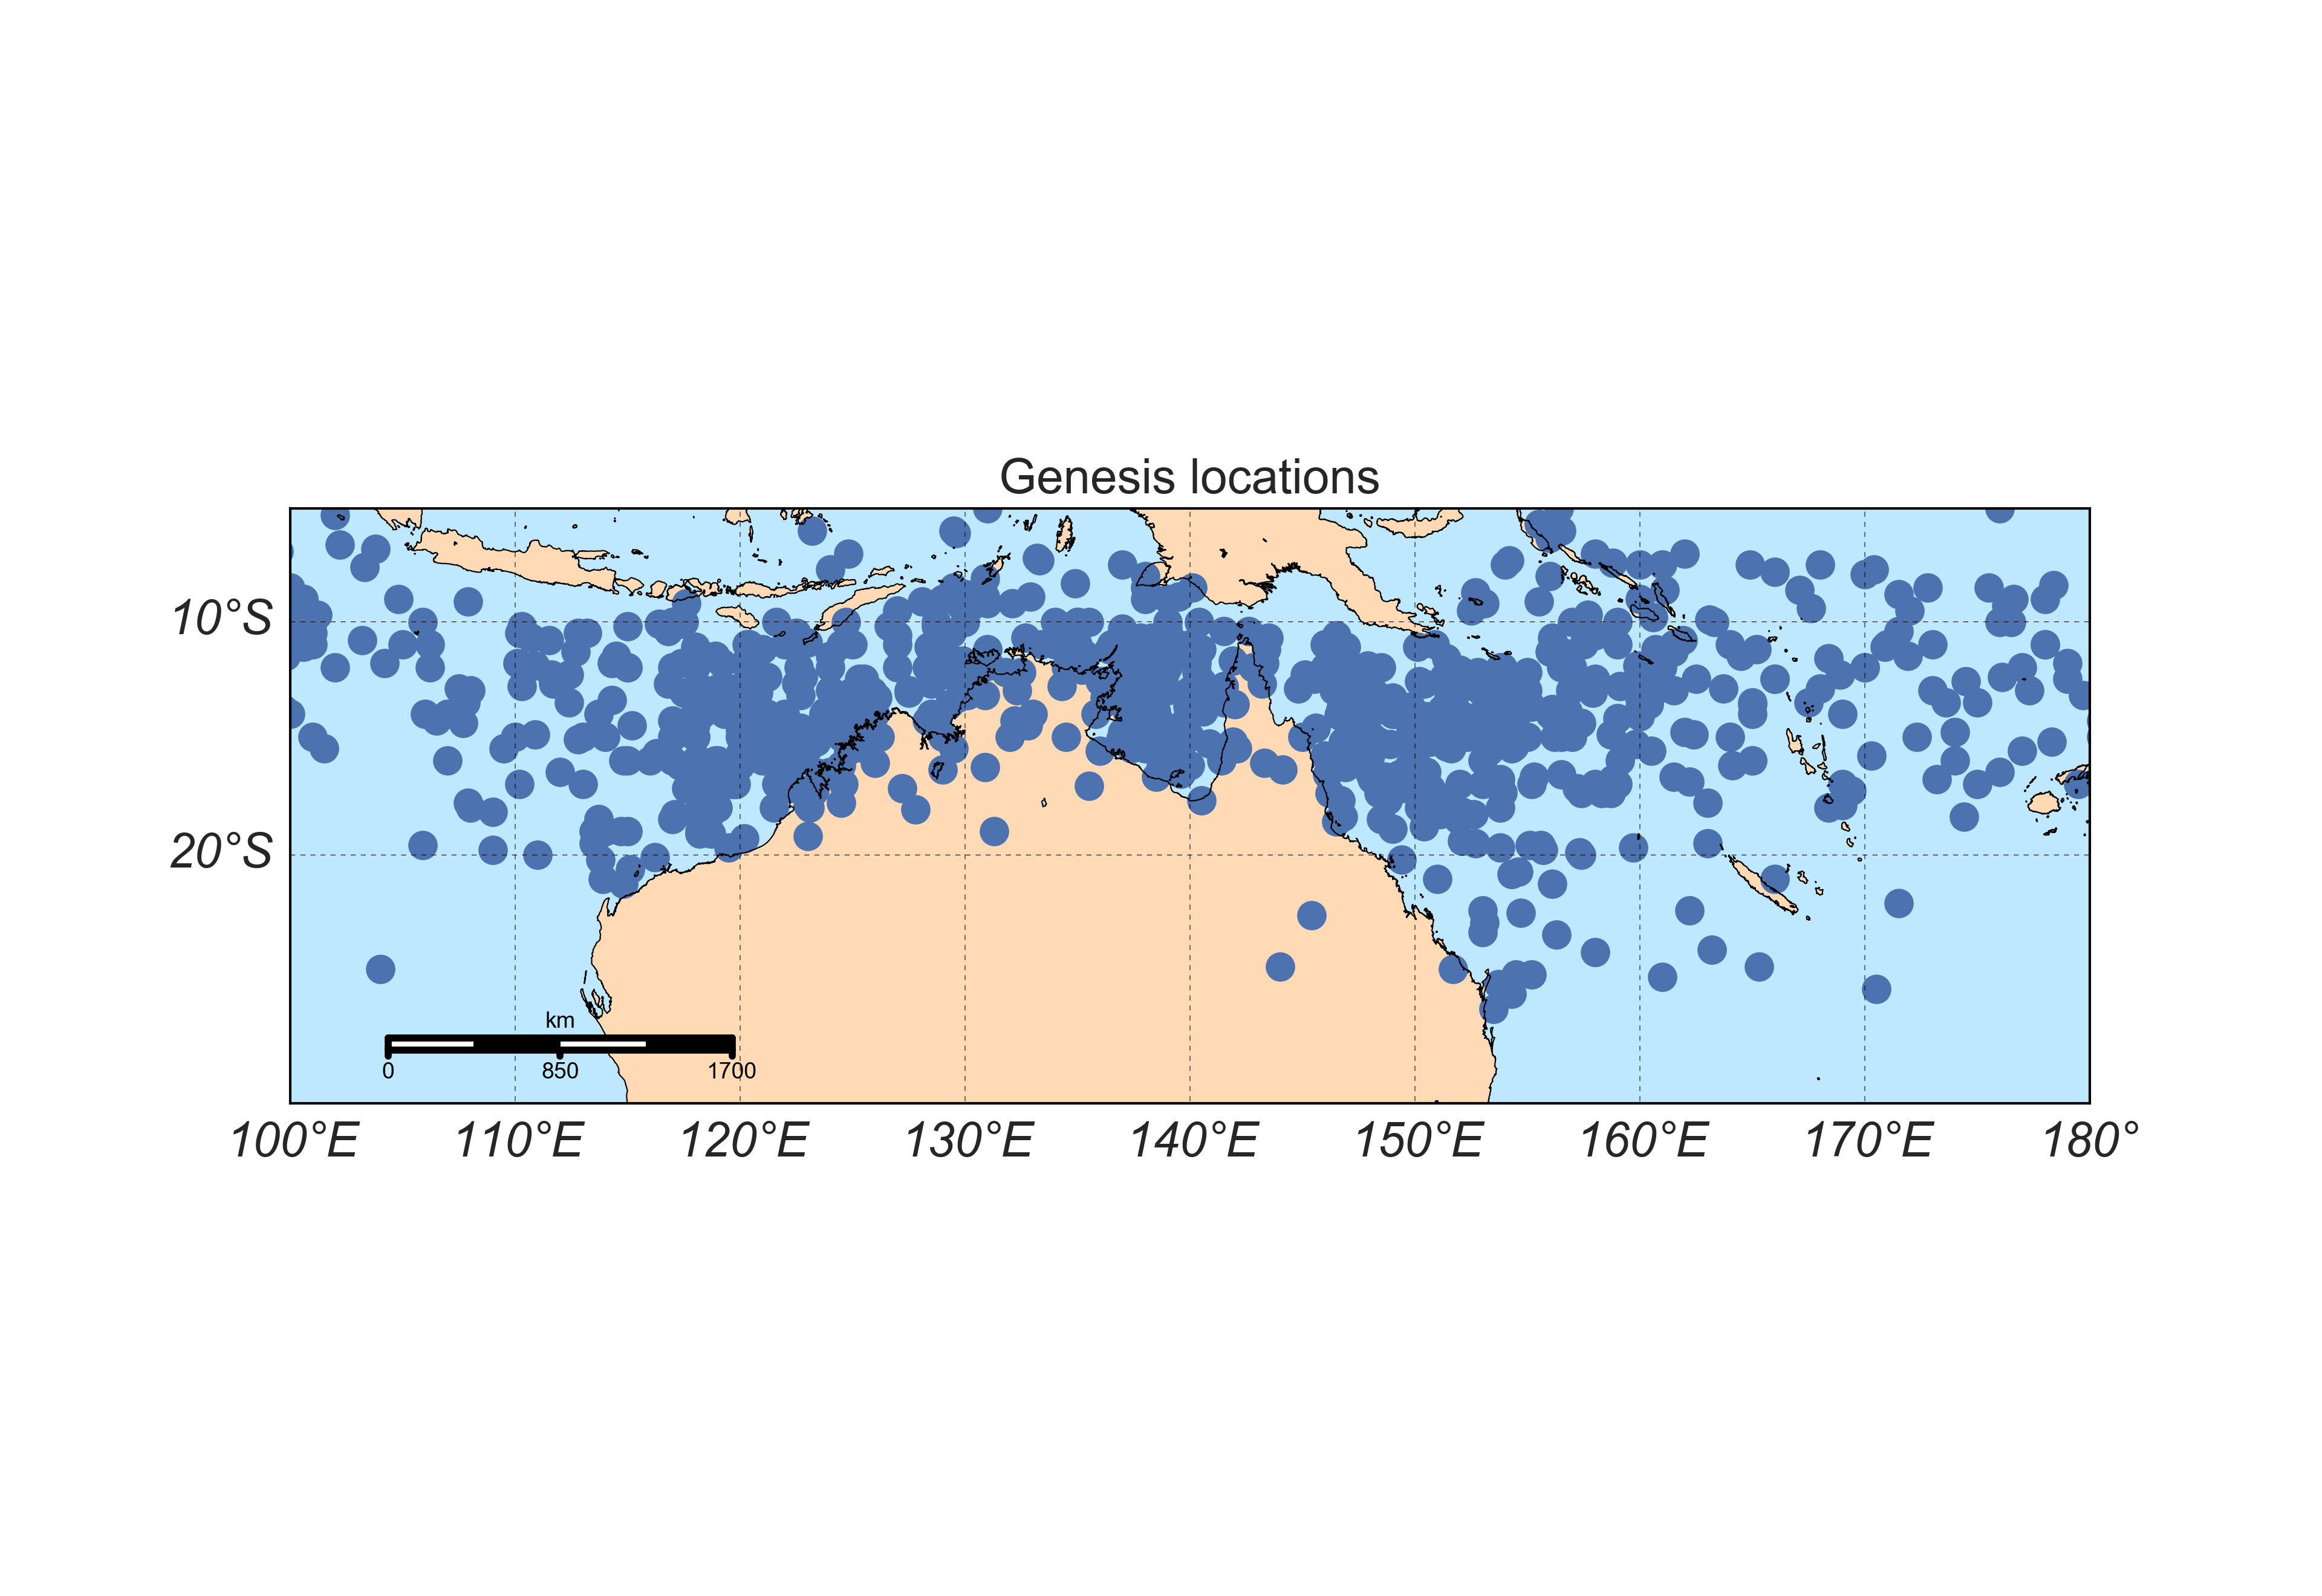

In [9]:
x = np.arange(gridLimit['xMin'], gridLimit['xMax'], 0.1)
y = np.arange(gridLimit['yMin'], gridLimit['yMax'], 0.1)

xgrid, ygrid = np.meshgrid(x, y)
lvls = np.arange(0, 1., 0.1)
cbarlabel = ""
title = "Genesis locations"
mapkwargs = dict(llcrnrlon=100., llcrnrlat=-30,
                  urcrnrlon=180., urcrnrlat=-5.,
                  resolution='h', projection='merc')
data = np.stack((olon, olat))

f = ScatterMapFigure()
f.add(data, xgrid, ygrid, title, lvls, cbarlabel, mapkwargs)
f.plot()
saveFigure(f, "Genesis.png")
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
Image("Genesis.png")

## Generating random genesis points

Here we demonstrate how TCRM generates random genesis points. 

Firstly, the model uses the historical genesis points as input to a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) routine to generate a 2-dimensional probability density function (PDF) of genesis probability.

In [7]:
from StatInterface.KDEOrigin import KDEOrigin

kdeStep = 0.1 # Grid resolution
origin = KDEOrigin(configstr, gridLimit, kdeStep, lonLat=data.T)
ox, oy, pdf = origin.generateKDE()

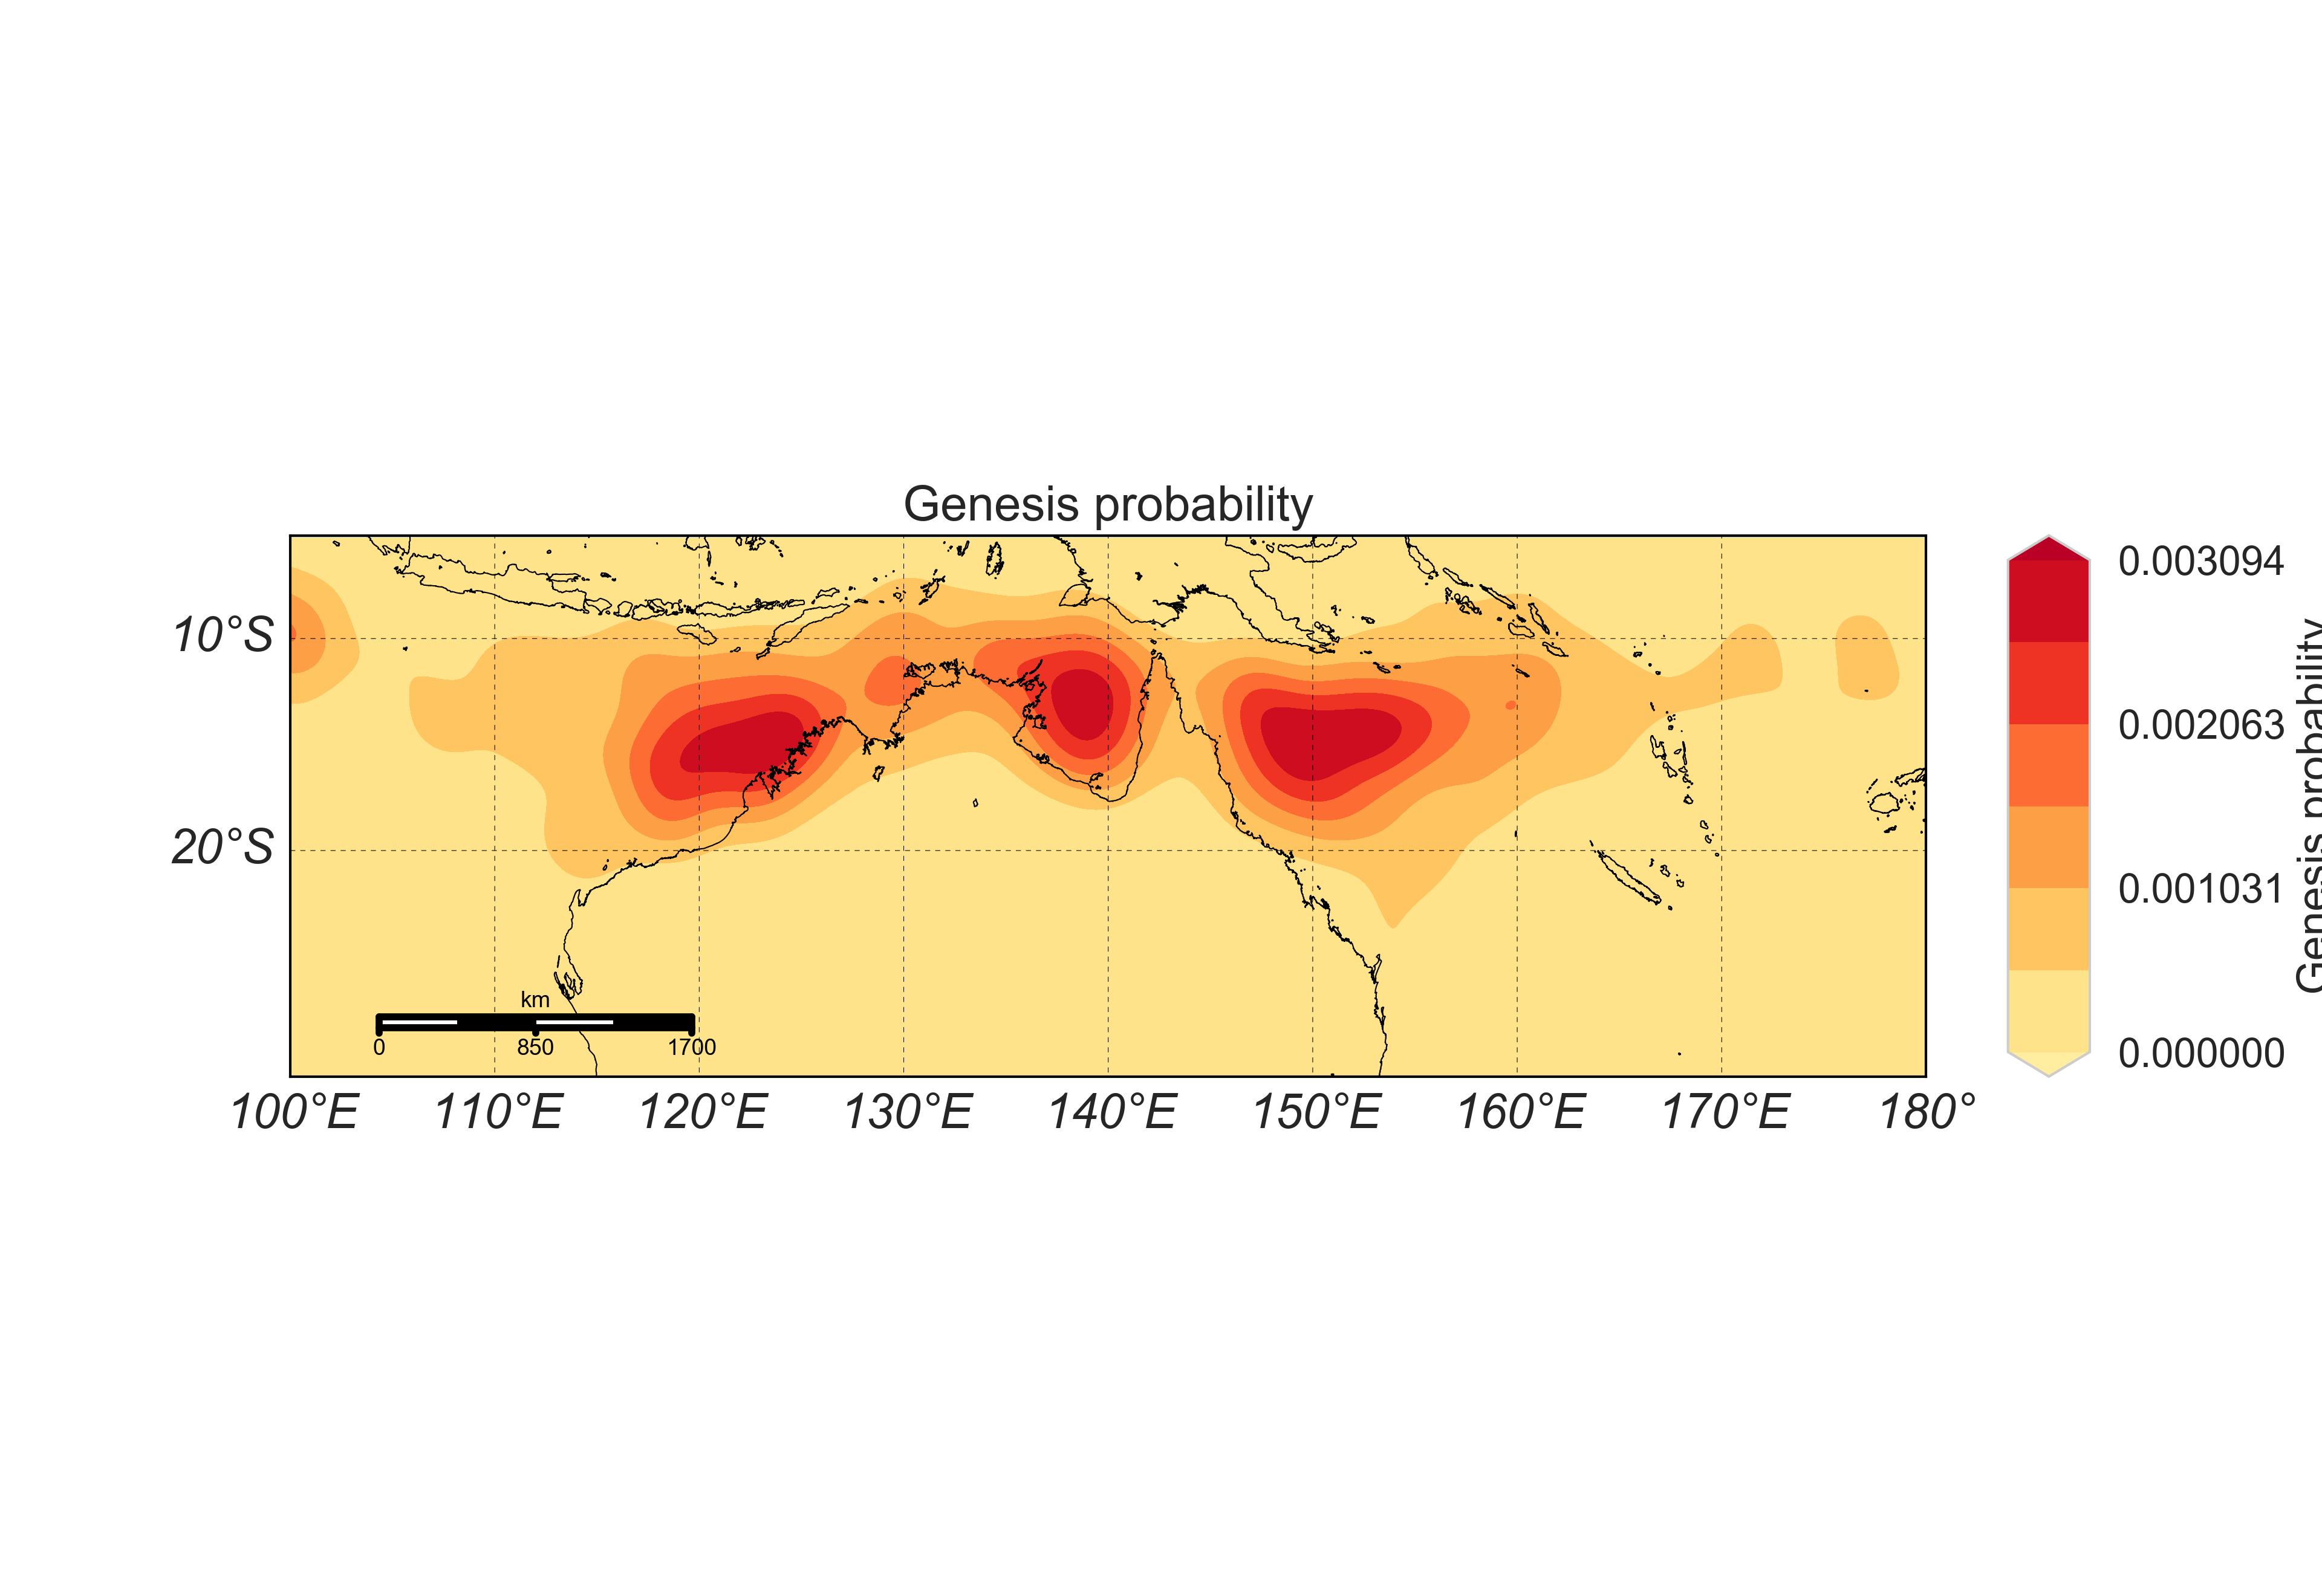

In [10]:
lvls = np.linspace(0, pdf.max(), 7)
cbarlabel = "Genesis probability"
title = "Genesis probability"
f = FilledContourMapFigure()
f.add(np.flipud(pdf.T), xgrid, ygrid, title, lvls, cbarlabel, mapkwargs)
f.plot()
saveFigure(f, "genesis_pdf.png")
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
Image("genesis_pdf.png")

This map shows the probability of a cyclone forming at any point in a 0.1 x 0.1 degree grid square, based on historical TC occurrence. Or more correctly, based on the first recorded location of historical TCs. Given satellites only launched in the 1960's, there's a huge part of the record where we don't know where the cyclone actually formed, only where it was first recorded - usually closer to trade routes and coastal communities. We'll explore that issue later. 

The smoothness of the genesis PDF is related to the density of observations over the entire region. If there are more observations, then the bandwidth of the KDE is smaller, and more detail can emerge. In this case, we use a 2-d bandwidth, so the kernel can (and indeed does) have different bandwidths in the longitude and latitude directions.

## Changing the bandwith of the KDE

To demonstrate the influence of bandwidth on the resulting PDF, you can modify the x- and y-bandwidths and see what happens to the PDF.

In [11]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import cartopy.crs as ccrs

# This is not the method by which we'd normally plot maps, but we do 
# so here to get the interactive capability in a notebook.
def plotKDE(pdf, xgrid, ygrid, title, levels, cbarlabel, mapkwargs):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    palette = sns.color_palette("YlOrRd", 7)
    cmap = sns.blend_palette(palette, as_cmap=True)
    cs = ax.contourf(xgrid, ygrid, pdf, extend='max', cmap=cmap)
    
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.gridlines(linestyle=":", draw_labels=True)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(cs, orientation='vertical', extend='max', shrink=0.75, aspect=20)
    plt.show()
    
def varyBandwidth(lonLat, gridLimit, kdeStep, bx, by):
    x = np.arange(gridLimit['xMin'], gridLimit['xMax'], kdeStep)
    y = np.arange(gridLimit['yMax'], gridLimit['yMin'], -kdeStep)
    ii = np.where((lonLat[:, 0] >= gridLimit['xMin']) &
                    (lonLat[:, 0] <= gridLimit['xMax']) &
                    (lonLat[:, 1] >= gridLimit['yMin']) &
                    (lonLat[:, 1] <= gridLimit['yMax']))

    lonLat = lonLat[ii]
    bw = [bx, by]
    kde = KDEMultivariate(lonLat, bw=bw, var_type='cc')
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack([xx.ravel(), yy.ravel()])
    mpdf = kde.pdf(data_predict=xy)
    mpdf = mpdf.reshape(xx.shape)

    mpdf = mpdf.transpose()
    plotKDE(np.flipud(mpdf.T), xgrid, ygrid, title, lvls, cbarlabel, mapkwargs)

    

bxSlider = FloatSlider(value=origin.bw[0], min=0.5, max=2.5, step=0.05, description="x-bandwidth", continuous_update=False)
bySlider = FloatSlider(value=origin.bw[1], min=0.5, max=2.5, step=0.05, description="y-bandwidth", continuous_update=False)


Using the sliders below, change the bandwidth for the x- and y-directions. **It does take about a minute to perform the computation each time you change the values, so change one first and review the plot, then change the other.** 

<IPython.core.display.Javascript object>


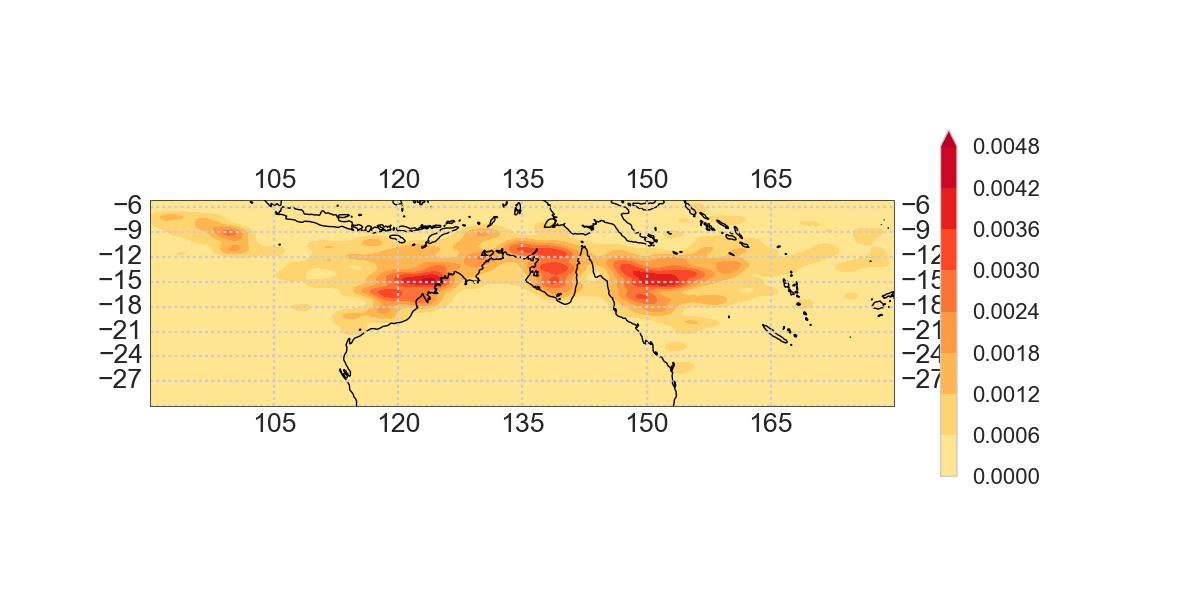

In [12]:
f = interact(varyBandwidth, lonLat=fixed(data.T), 
                gridLimit=fixed(gridLimit), 
                kdeStep=fixed(kdeStep), 
                bx=bxSlider, by=bySlider)

#### Questions:

- If you set the bandwidths for both dimensions to the smallest possible value, what is the maximum probability of genesis (hint, look at the colorbar)? 
- What if you set the bandwidths to be the largest possible values?
- What might happen to the PDF if you started with fewer genesis points? What about more genesis points?

## Random sampling of genesis points

Now that we have a PDF of random genesis points, we can randomly sample starting points for the synthetic event set from this probability cloud. This is performed in the `SamplingOrigin` class in the `StatInterface` module. You pass it the PDF of historical genesis points, and you can then tell it to generate any number of random genesis points from the PDE. 

First instantiate the `SamplingOrigin` class, passing it the grid and the PDF calculated above.

In [13]:
from StatInterface.SamplingOrigin import SamplingOrigin
SO = SamplingOrigin(kdeOrigin=np.flipud(pdf.T), x=x, y=y)

Now we call the `generateSamples` method on the `SO` class to generate the genesis points. In this example, the number of genesis points is set to match the number of tracks that were identified above in the simulation region (`len(tracks)`).

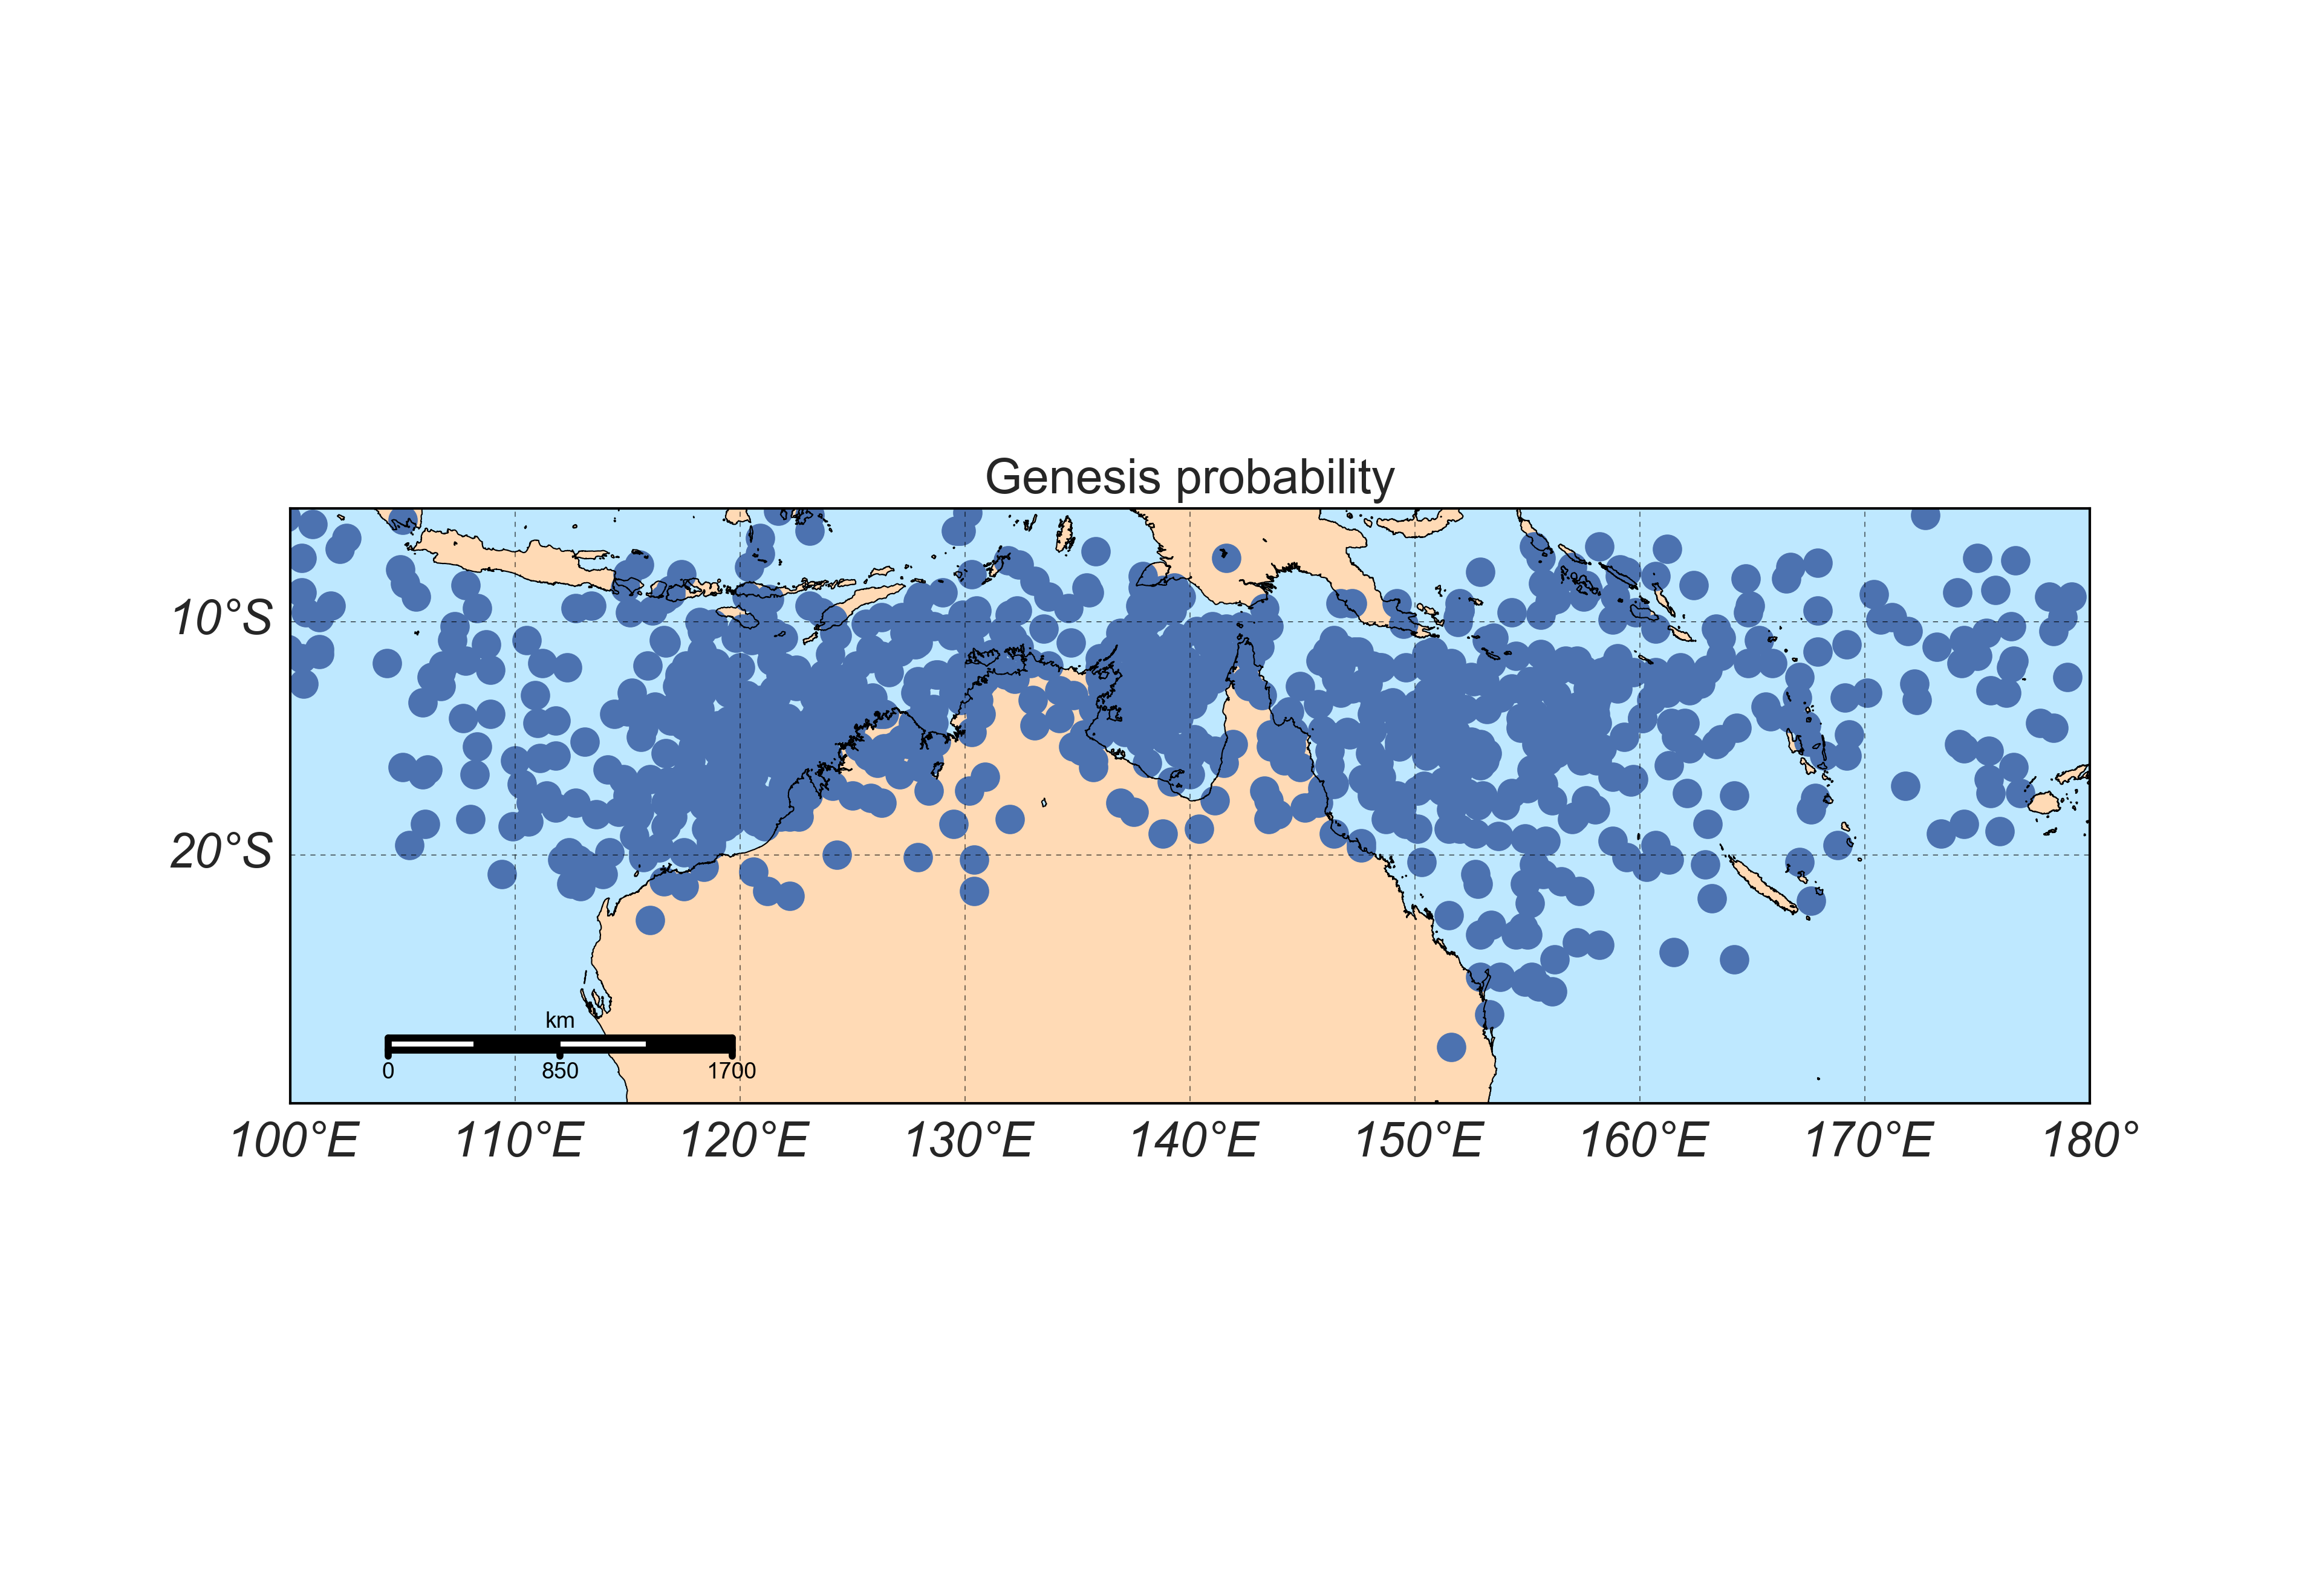

In [14]:
sampleLonLat = SO.generateSamples(len(tracks))
sLon = sampleLonLat[:, 0]
sLat = sampleLonLat[:, 1]
f = ScatterMapFigure()
f.add(np.stack((sLon, sLat)), xgrid, ygrid, title, lvls, cbarlabel, mapkwargs)
f.plot()
saveFigure(f, "random_genesis.png")
Image("random_genesis.png")

Return to the historical genesis points and compare the figures. There are the same number of points, but you should notice that they are different. Arguably, you could possibly generate a set of random genesis points that exactly matched the historical points, however this would be exceptionally improbable. 

#### Questions:
- What might happen if you selected a different bandwidth when defining the PDF using kernel density estimation?
- What might happen to synthetic TCs that have their genesis points at high latitudes (a long way south)?
- Can this process return genesis points outside of the previously observed genesis regions?